In [3]:
from module import decomposition
from module import dickey_fuller
from module import arima_endog
from module import arima_exog
from module import rmse_cv
from module import lasso_reg


import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import hstack
import warnings
import os
from fredapi import Fred
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm
from pmdarima import model_selection

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

%matplotlib inline
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set Datetime

In [4]:
start = datetime(2000,2,1)
end = datetime(2020,1,31)

## Gather Endogenous Data 

In [5]:
ELS = web.DataReader('ELS', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
ELS = ELS.copy()
ELS.index = pd.to_datetime(ELS.index)
ELS = ELS.resample('MS').mean()
ELS['mid'] = (ELS['high']+ELS['low'])/2
ELS.drop(labels = ['high', 'low', 'open', 'close', 'volume'], axis = 1, inplace = True)

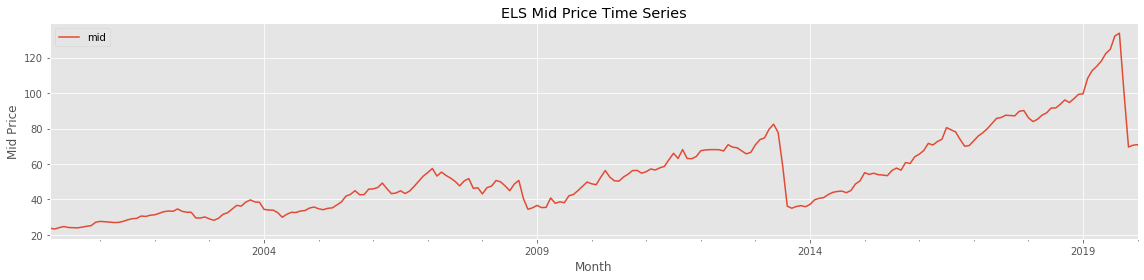

In [6]:
plt.style.use('ggplot')
ELS.plot(figsize = (16,4))
plt.xlabel('Month')
plt.ylabel('Mid Price')
plt.title('ELS Mid Price Time Series')
plt.tight_layout()
plt.show();

## Perform Decomposition of Time Series

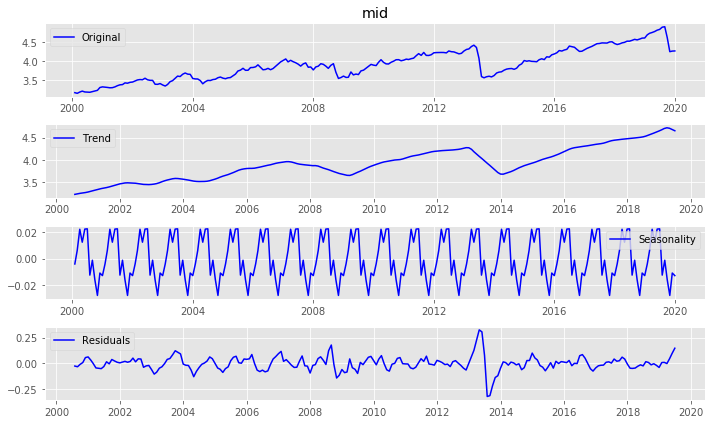

In [7]:
decomposition(ELS)

In [8]:
ELS_diff = ELS.diff(periods = 1).dropna()

In [9]:
dickey_fuller(ELS_diff)

The series passes the Dickey Fuller Test for Stationarity. P-Value = 3.364492668109627e-19


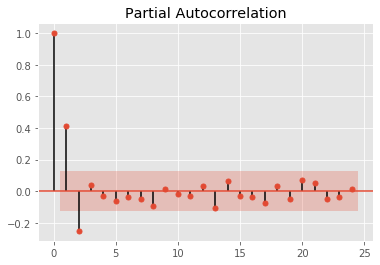

In [16]:
plot_pacf(ELS_diff);

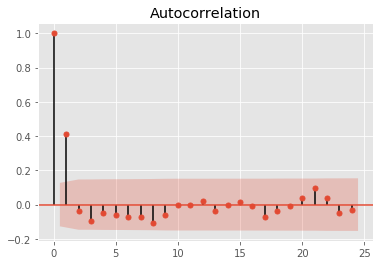

In [11]:
plot_acf(ELS_diff);

## Train Test Split

In [12]:
ELS_train = ELS[:'2017']
ELS_test = ELS['2018':]

## SARIMAX Model (No Exogenous Variables)

Summary:                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  215
Model:             SARIMAX(2, 1, 4)x(2, 1, 4, 12)   Log Likelihood                -388.450
Date:                            Mon, 10 Feb 2020   AIC                            804.900
Time:                                    15:33:33   BIC                            846.955
Sample:                                02-01-2000   HQIC                           821.986
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0010      0.002      0.506      0.613      -0.003       0.005
ar.L1         -0.0984     

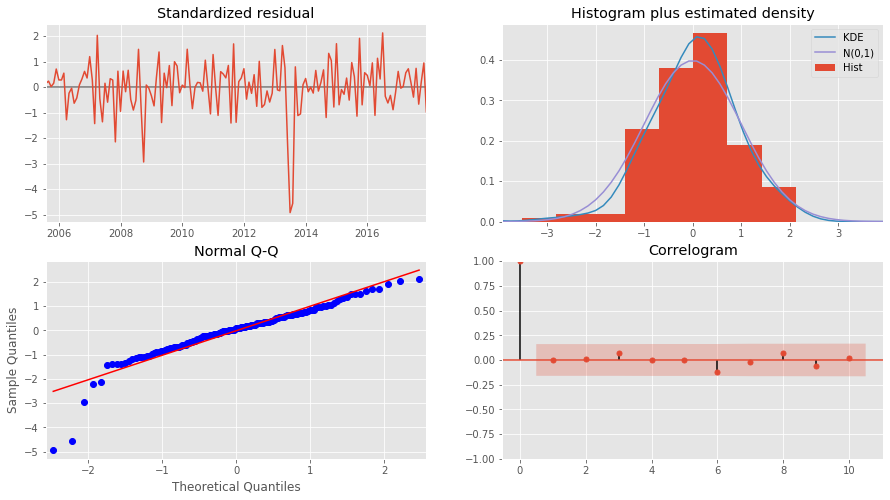

--------------------------------------------------------------------------------------------------------------------------------------------------------------
 
Predictions vs. Observed: 
 


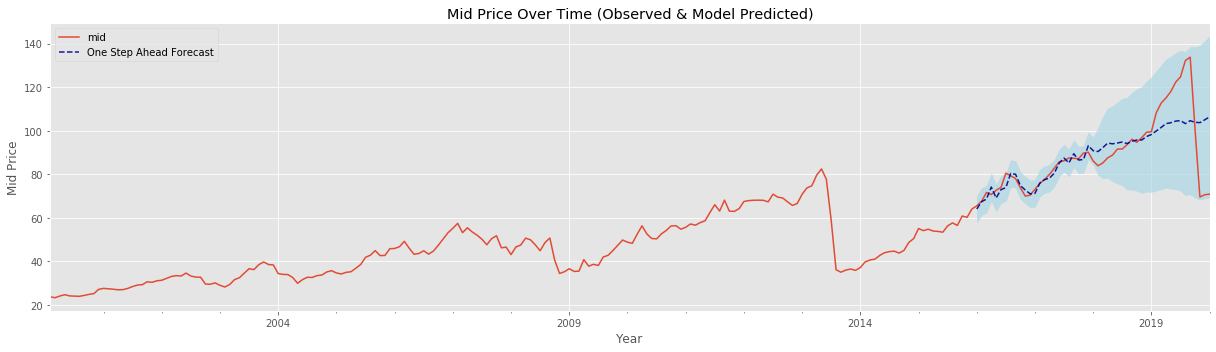

In [21]:
arima_endog(ELS_train, ELS, (2,1,4), (2,1,4,12))

## Gather Exogenous Variables

In [64]:
ELS_rates = pd.read_csv('data/ELS_rates.csv', index_col = 'date')

### Train Test Split Exogenous Variables

### Perform Lasso Regression

The R-score of the Lasso Regression is: 0.8939007612743599

usd1mtd156n      -0.000000
mortgage30us     -0.000000
mortgage15us     -0.000000
dcpf3m           -0.000000
cpn3m            -0.000000
dcpf1m           -0.000000
aaa              -0.000000
baa              -0.000000
dff              -0.000000
flexsc           -0.000000
t10y2y           -0.000000
t10y3m           -0.000000
tedrate          -0.000000
t10yff           -0.000000
t5yff            -0.000000
tb6smffm         -0.000000
usd3mtd156n      -0.000000
usd12md156n      -0.000000
eur1wkd156n      -0.000000
mprime           -0.000000
tb3ms            -0.000000
dtb6             -0.000000
dgs10            -0.000000
dgs3mo           -0.000000
dexuseu           0.000000
dexchus          -0.000000
dexusuk          -0.000000
dexsius          -0.000000
nasdaqcom         0.005112
willreitind       0.004831
willlrgcap       -0.001561
willsmlcap        0.000154
vxdcls            0.095614
stlfsi           -0.000000
nfci              0.00

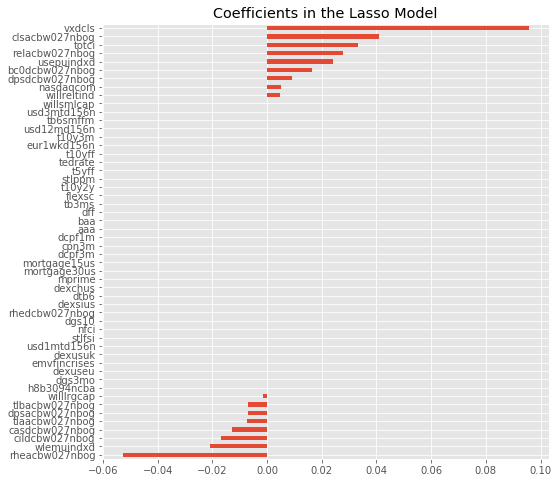

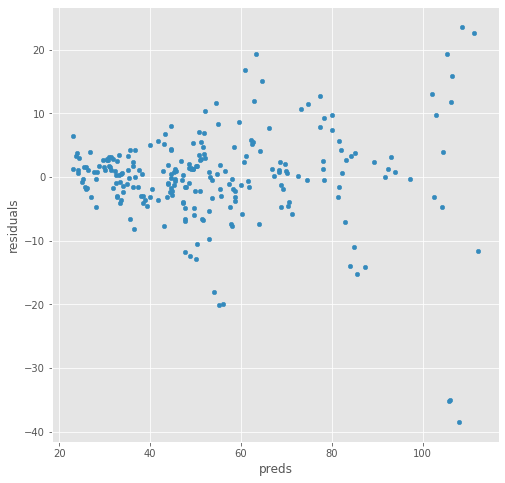

In [65]:
lasso_reg(ELS_rates)

### Select significant exogenous features from Lasso Regression

In [66]:
ELS_rates_train = ELS_rates[:'2018']
ELS_rates_test = ELS_rates['2018':]

In [67]:
exog_train = ELS_rates_train[['vxdcls', 'clsacbw027nbog', 'totci', 'relacbw027nbog', 'usepuindxd', 'bc0dcbw027nbog', 'rheacbw027nbog']]

In [68]:
exog_test = ELS_rates_test[['vxdcls', 'clsacbw027nbog', 'totci', 'relacbw027nbog', 'usepuindxd', 'bc0dcbw027nbog', 'rheacbw027nbog']]

In [69]:
exog_train.shape, exog_test.shape

((215, 7), (25, 7))

Summary:                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  215
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -434.072
Date:                            Mon, 10 Feb 2020   AIC                            902.143
Time:                                    14:14:34   BIC                            955.945
Sample:                                02-01-2000   HQIC                           923.967
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
drift             -0.0003      0.001     -0.271      0.787      -0.002       0.002
vxdcls        

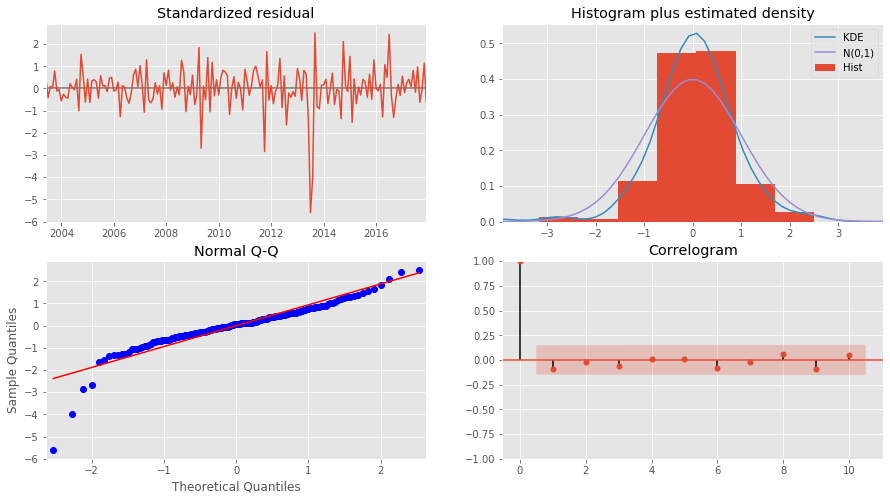

In [70]:
arima_model = sm.tsa.statespace.SARIMAX(ELS_train,
                                        exog = exog_train,
                                        order = (2,1,2),
                                        seasonal_order = (2,1,2,12),
                                        enforce_stationarity = False,
                                        enforce_invertability = False,
                                        trend = 't')
results = arima_model.fit()
print(f'Summary: {results.summary()}')
print()
print('Diagnostics: ')
results.plot_diagnostics(figsize = (15,8))
plt.show()

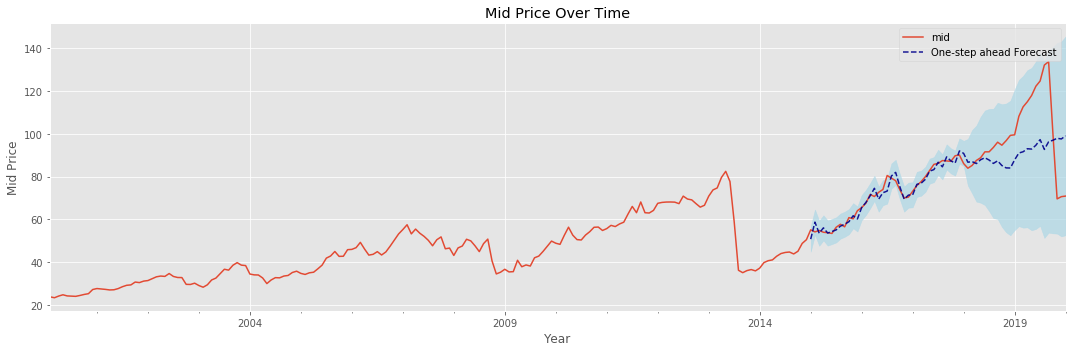

In [71]:
predictions = results.get_prediction(start = pd.to_datetime('2015-01-01'), end = pd.to_datetime('2020-01-01'), dynamic=False, exog = exog_test)
pred_conf = predictions.conf_int()
    
#Plot observed values
ax = ELS['2000-02-01':].plot(label='observed', figsize = (15,5))

#Plot predicted values
predictions.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9, color = 'darkblue', style = '--')

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='lightblue', alpha=.7)

#Set axes labels
ax.set_xlabel('Year')
ax.set_ylabel('Mid Price')
plt.legend(loc = 'best')
plt.title(f'Mid Price Over Time')
plt.tight_layout()
plt.show()
    